In [4]:
import os
os.chdir('/mnt/nas_siddharth/code_final/')

import cv2
import numpy as np
import matplotlib.pyplot as plt

from src.pipeline.step1_proc2d import init_all_models

DEVICE   = 'cuda:0'

detector, tracker, pose_model, test_pipeline_orig, id_model_all = init_all_models(DEVICE)

06/12 11:03:31 - mmengine - INFO - [INFO] Initializing models on device: cuda:0
06/12 11:03:32 - mmengine - WARNING - The current default scope "mmpose" is not "mmdet", `init_default_scope` will force set the currentdefault scope to "mmdet".
Loads checkpoint by local backend from path: ./model/detection/detection.pth
06/12 11:03:35 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".
Loads checkpoint by local backend from path: ./model/pose/pose.pth
Loads checkpoint by local backend from path: ./model/id/id_finetuned.pth
06/12 11:03:49 - mmengine - INFO - [INFO] All models initialized.


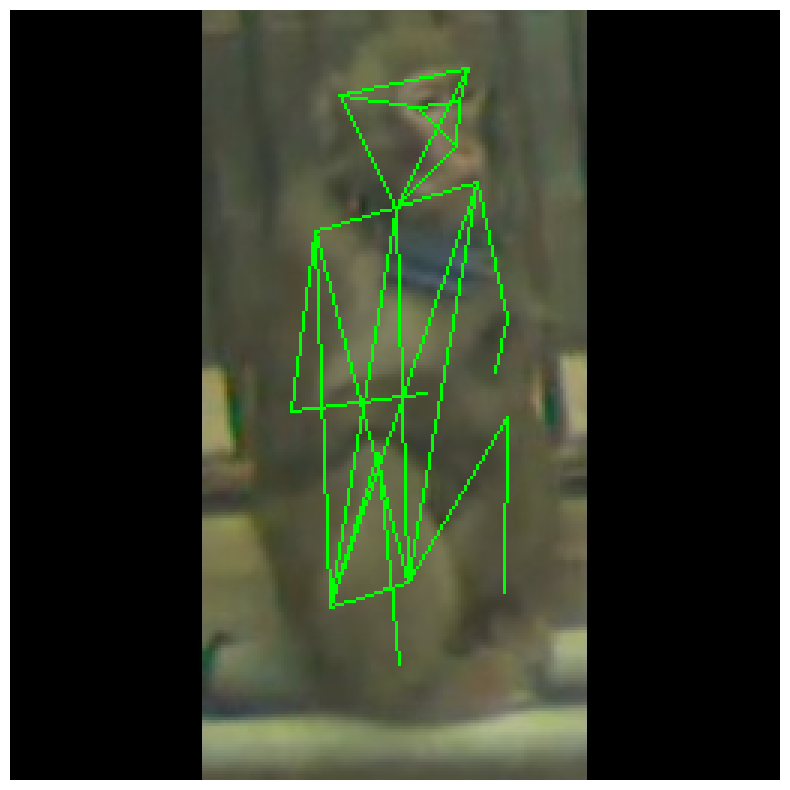

In [6]:
img_path = '/mnt/nas_siddharth/code_final/notebooks/img/test_image_2.jpg'
#img_path = '/mnt/nas_siddharth/code_final/notebooks/img/test_image.jpg'

from mmcv.transforms import Compose

test_pipeline = Compose([
    {"type": "mmdet.LoadImageFromNDArray"},
    {"type": "Resize", "scale": (800, 800), "keep_ratio": True},
    {"type": "mmdet.LoadAnnotations", "with_bbox": True},
    {"type": "mmdet.PackDetInputs"},
])

def detect_and_pose_on_image(img_path, detector, pose_model, test_pipeline):
    img = cv2.imread(img_path)
    assert img is not None, f"Cannot load {img_path}"
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    from mmdet.apis import inference_detector
    det_result = inference_detector(detector, [img], test_pipeline=test_pipeline)[0]
    bboxes = det_result.pred_instances.bboxes.cpu().numpy()
    scores = det_result.pred_instances.scores.cpu().numpy()
    score_thr = 0.3
    keep = scores > score_thr
    bboxes = bboxes[keep]

    person_results = [{"bbox": bbox} for bbox in bboxes]

    from mmpose.apis import inference_topdown
    if len(person_results) > 0:
        pose_results = inference_topdown(
            pose_model, img,
            bboxes=np.array([r["bbox"] for r in person_results], dtype=np.float32),
            bbox_format="xyxy",
        )
    else:
        pose_results = []
    return img_rgb, pose_results

skeleton_pairs = [
    (1, 2),
    (0, 1),   # nose - left eye
    (0, 2),   # nose - right eye
    (1, 3),   # left eye - left ear
    (2, 4),   # right eye - right ear
    (3, 4),   # left ear - right ear
    (0, 17),  # nose - neck
    (3, 17),  # left ear - neck
    (4, 17),  # right ear - neck
    (17, 5),  # neck - left shoulder
    (17, 6),  # neck - right shoulder
    (5, 6),   # left shoulder - right shoulder
    (17, 11), # neck - left hip
    (17, 12), # neck - right hip
    (11, 12), # left hip - right hip
    (5, 7),   # left shoulder - left elbow
    (7, 9),   # left elbow - left wrist
    (6, 8),   # right shoulder - right elbow
    (8, 10),  # right elbow - right wrist
    (11, 13), # left hip - left knee
    (13, 15), # left knee - left ankle
    (12, 14), # right hip - right knee
    (14, 16), # right knee - right ankle
    # Diagonals for torso
    (5, 11),  # left shoulder - left hip
    (6, 12),  # right shoulder - right hip
    (5, 12),  # left shoulder - right hip
    (6, 11),  # right shoulder - left hip
    ]
cm = plt.get_cmap('hsv', 36)
#skeleton_pairs = [
#    #(0,2), # nose - right eye
#    #(0,1), # nose - left eye
#    (0,3), # nose - left ear
#    (0,4), # nose - right ear
#    #(2,4), # right eye - right ear
#    #(1,3), # left eye - left ear
#    #(0,4), # nose - right ear
#    #(0,3), # nose - left ear
#    (6,8), # right shoulder - right elbow
#    (5,7), # left shoulder - left elbow
#    (8,10), # right elbow - right wrist
#    (7,9), # left elbow - left wrist
#    (12,14), # right hip - right knee
#    (11,13), # left hip - left knee
#    (14,16), # right knee - right ankle
#    (13,15), # left knee - left ankle
#    (0,17), # nose - neck
#    (17,6), # neck - right shoulder
#    (17,5), # neck - left shoulder
#    (17,12), # neck - right hip
#    (17,11) # neck - left hip
#    ]

def draw_kps_cv2(img, kpts, skeleton_pairs, clr=(0,255,0)):
    #for i, (x, y, score) in enumerate(kpts):
    #    if score > 0.2:
    #        cv2.circle(img, (int(x), int(y)), 2, clr, -1)
    for i1, i2 in skeleton_pairs:
        if kpts[i1][2]>0.2 and kpts[i2][2]>0.2:
            pt1 = (int(kpts[i1][0]), int(kpts[i1][1]))
            pt2 = (int(kpts[i2][0]), int(kpts[i2][1]))
            cv2.line(img, pt1, pt2, clr, 1)
    return img

img_rgb, pose_results = detect_and_pose_on_image(
    img_path, detector, pose_model, test_pipeline
)

img_vis = img_rgb.copy()
for res in pose_results:
    kpts = res.pred_instances.keypoints[0]
    scores = res.pred_instances.keypoint_scores[0]
    if not (np.isnan(kpts[5]).any() or np.isnan(kpts[6]).any()):
        neck_xy = (kpts[5] + kpts[6]) / 2.0
        neck_score = (scores[5] + scores[6]) / 2.0
    else:
        neck_xy = np.array([np.nan, np.nan])
        neck_score = 0.0
    kpts18 = np.vstack([kpts, neck_xy])
    scores18 = np.concatenate([scores, [neck_score]])
    kpts_vis = np.concatenate([kpts18, scores18[:, None]], axis=1)
    img_vis = draw_kps_cv2(img_vis, kpts_vis, skeleton_pairs)


plt.figure(figsize=(10,10))
plt.imshow(img_vis)
plt.axis('off')
plt.show()

